# Gaussian Process Classification

Gaussian process are not only used for regression, but also for classification problems. Gaussian process classification uses a latent regression model to predict class probabilities. In a first step, we discuss binary classification and afterwards the setting is generalized to multiclass classification.

(sec:binaryclass)=
## Binary Classification

In binary classification the data $\mathcal{D}$ is of the form

$$\mathcal{D} = \{ (x_i, y_i)~|~x_i \in \mathbb{R}^d, y_i \in \{-1, 1\} \quad \text{for } i=1,\dots,n \},$$

i.e., the (discrete) label has either value $-1$ or $1$ representing the two possible classes. The sample matrix $X$ and the lables $y$ are constructed as before.

For a test point $x^*$, the aim is to predict the **class probabilities** of the output $y^*$, i.e., the probabilities $p(y^*=1~|~X, y, x^*)$ and $p(y^*=-1~|~X, y, x^*)$. In this way, we obtain one discrete probability distribution on $\{-1, 1\}$ for each $x^*$. Since 

$$p(y^*=-1~|~X, y, x^*) = 1 - p(y^*=1~|~X, y, x^*),$$

it is sufficient to focus on $p(y^*=1~|~X, y, x^*)$. In other words, we are looking for a model which returns for a given input $x^*$ the probability that the corresponding label is $1$. For example, $x^*$ could be an image which shows either a cat or a dog. The model has to quantify the probability for dog and the complementary probability yields the probability for cat. Certainly, we desire values close to 0 or 1, since values near 0.5 imply that the model has difficulties to classify the input.

It holds $\sigma(z) \in [0,1]$, where 

$$\sigma(z) := \frac{1}{1 + \exp(-z)} \quad \text{for } z \in \mathbb{R}$$(deflogfct)

is the **logistic response function**. 

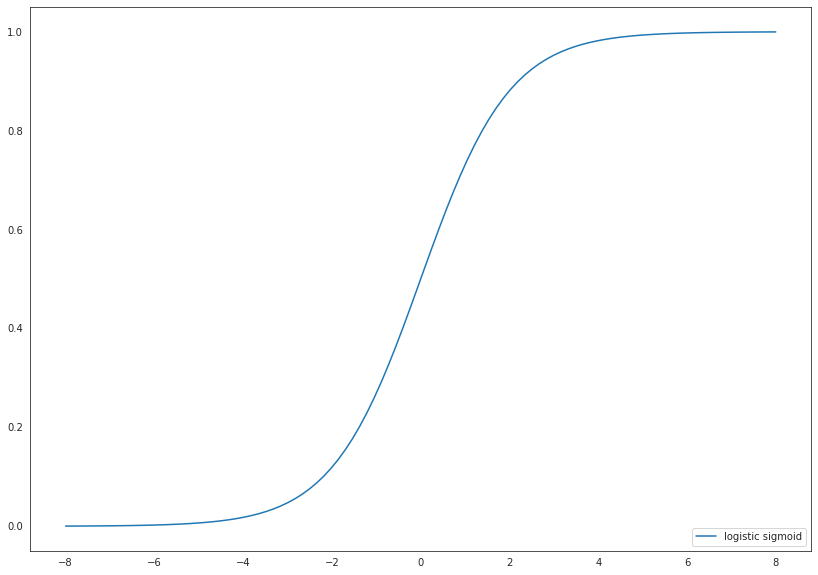

In [1]:
%matplotlib inline
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

fig = plt.figure(figsize=(14, 10))
x = np.linspace(-8, 8, num=100)
plt.plot(x, expit(x), label='logistic sigmoid')
leg = plt.legend(loc='lower right')

Hence, the value of $\sigma(z)$ can be interpreted as a probability. It is also possible to use other response functions such as the Gaussian cdf, but we will restrict to $\sigma$.

Our aim is to construct the **distribution of a latent variable** $f^*$ given the data $\mathcal{D}$ and a test point $x^*$ (denote the pdf by $p(f^*~|~X, y, x^*)$) such that the class probability can be computed by the expectation of $p(y^*=1~|~f^*) := \sigma(f^*)$:

$$
p(y^*=1~|~X, y, x^*) &= \int_{\mathbb{R}} ~ p(y^*=1~|~f^*)~p(f^*~|~X, y, x^*)~df^* \\
&= \int_{\mathbb{R}} ~ \sigma(f^*)~p(f^*~|~X, y, x^*)~df^*.
$$ (classprob)

Please note that $p(y^*=-1~|~f^*) = 1 - p(y^*=1~|~f^*) = 1 - \sigma(f^*) = \sigma(-f^*)$ due to the properties of the logistic response function. Thus, the notation $p(y^*~|~f^*) = \sigma(y^* f^*)$ is also used. Moreover, we like to mention that $f^* < 0$ suggests that $y^* = -1$ is more likely and vice versa $f^* > 0$ implies that $y^* = 1$ is more likely.

*How can we construct $p(f^*~|~X, y, x^*)$ in* {eq}`classprob` *by means of Gaussian process regression*? 

The answer to this question is rather complicated and technical. For the interested reader, we give the details in the subsequent part:

````{admonition} Explanation.
:class: dropdown
We follow the explanation in sections 3.3 and 3.4 of {cite}```Rasmussen2006```.

In Gaussian process regression we constructed a similar distribution $p(f^*~|~X, f, x^*)$ representing the {ref}```posterior over functions<lem:gpregr>``` in terms of conditional distributions. Hence, the approach

$$p(f^*|~X, y, x^*) = \int_{\mathbb{R}^n} ~ p(f^*~|~X, f, x^*)~p(f~|~X, y)~df$$ (latentdistr)

is useful and natural, since it reduces the problem to determine the **distribution of the latent labels** $f$ given the observations $X$ and $y$. Note that we denote the continuous labels by $f$ instead of $y$, since $y$ is used for the discrete class labels.

At this point, it is already evident that **Gaussian process classification is more challenging than regression**. It is required to determine the pdf $p(f~|~X, y)$ of an unobserved variable $f$ and afterwards two integrals have to be calculated which involve the posterior distribution function of a Gaussian process regression model.

*How can we compute $p(f~|~X, y)$ in* {eq}`latentdistr`? 

Bayes' theorem yields

$$p(f ~|~X, y) = \frac{p(y~|~X, f) ~ p(f~|~X)}{p(y~|~X)} = \frac{p(y~|~f) ~ p(f~|~X)}{p(y~|~X)},$$ (Bayeslatentlabels)

since $y$ depends by assumption only on the latent variable $f$. In principle, we have all ingredients to create our classification model. Indeed, it holds 

$$p(y~|~f) = \prod_{i=1}^n p(y_i~|~f_i) = \prod_{i=1}^n \sigma(y_i f_i) = \prod_{i=1}^n  \frac{1}{1 + \exp(-y_i f_i)}$$(factclassprob)

and

$$p(y~|~X) = \int_{\mathbb{R^n}} p(y~|~f, X) ~p(f~|~X)~ df = \int_{\mathbb{R^n}} p(y~|~f) ~p(f~|~X)~df,$$

where $p(f~|~X)$ is the marginal likelihood of the Gaussian process. Please note that we assume that the labels $y$ are independent conditional on $f$ in order to factorize in {eq}`factclassprob`. However, the non-Gaussian likelihood $p(y~|~f)$ makes it analytically intracable to compute the integral in {eq}`latentdistr`.

Markov chain Monte Carlo (MCMC) methods are useful to compute the integrals. Another approach is the **Laplace approximation** of $p(f~|~X, y)$ by a Gaussian distribution function $q(f~|~X, y)$. The idea is to replace the unknown distribution by a suitable Gaussian distribution which is easier to handle. If we assume that $p(f~|~X, y)$ would be indeed the pdf of a normal distribution, then mean and covariance would be given by

$$\hat{f} := \underset{f}{\text{argmax}} ~ p(f~|~X, y)$$(Laplacemean)

and 

$$\Sigma_{\hat{f}} := \Big(- \nabla^2 \ln \big(p(f~|~X, y)\big)|_{f=\hat{f}}\Big)^{-1},$$(Laplacecov)

where $\nabla$ and $\nabla^2$ denote the first and second derivative, respectively. Thus, the Laplace approximation requires to find the maximum of a function depending on $f$. For this purpose, we compute the roots of the gradient. The quality of the Laplace approximation depends of course on the shape of the *real* distribution function. For simplification of the calculation, we make to following changes:

- instead of $p(f~|~X, y)$ consider $p(y~|~f) ~ p(f~|~X)$ in view of {eq}`Bayeslatentlabels`,
- apply $\ln$ to $p(y~|~f) ~ p(f~|~X)$

Thus, first $p(f~|~X, y)$ is scaled by a constant and afterwards the strictly increasing function $\ln$ is applied. A logarithmic transformation is useful, since it turns products into sums (which are easier to differentiate) and simplifies exponential terms. These modifications have no influence on the $\text{argmax}$. 

Set $\Psi(f) := \ln \big(p(y~|~f) ~ p(f~|~X)\big)$. It holds

$$ \Psi(f) &= \ln \big(p(y~|~f)\big) + \ln \big(p(f~|~X)\big) \\
           &= \ln \big(p(y~|~f)\big) - \frac{1}{2} f^T K(X, X)^{-1} f - \frac{1}{2} \ln \big(|K(X, X)|\big) - \frac{n}{2} \ln  \big(2 \pi\big)$$
           
Thus, the gradient is given by

$$ \nabla \Psi(f) = \nabla \ln \big(p(y~|~f)\big) - K(X, X)^{-1} f $$

and the Hessian by

$$ \nabla^2 \Psi(f) &= \nabla^2 \ln \big(p(y~|~f)\big) - K(X, X)^{-1} \\
                    &= -  W(f) - K(X, X)^{-1},$$
                    
where $W(f) := - \nabla^2 \ln \big(p(y~|~f)\big)$ is a diagonal matrix, since

$$\ln \big(p(y~|~f)\big) = \ln \big(\prod_{i=1}^n \sigma(y_i f_i)\big) = \sum_{i=1}^n \ln \big(\sigma(y_i f_i)\big)$$
           
$\hat{f}$ fulfills $\nabla \Psi(\hat{f}) = 0$ and hence, it holds

$$ \hat{f} = K(X, X) \nabla \ln \big(p(y~|~\hat{f})\big)$$(eqfhat)

Unfortunately, $\hat{f}$ also appears in the right-hand side of {eq}`eqfhat` and the equation can not be solved analytically. Therefore, another approximation is necessary. Roots of $\nabla \Psi$ can be computed by **Newton's method** in use of $\nabla^2 \Psi$:

- start with some initial value $f_0$
- for $i=0, 1, \dots$ compute iteratively

  $$ f_{i+1} = f_i - \big(\nabla^2 \Psi(f_i)\big)^{-1} \nabla \Psi(f_i)$$
  
  until some stopping criterion is met
- denote the result as $\hat{f}$

Thus, $p(f~|~X, y)$ is replaced by the density $q(f~|~X, y)$ of a $\mathcal{N}(\hat{f}, \Sigma_{\hat{f}})$-distributed random variable with 

$$\Sigma_{\hat{f}} = \big(W(\hat{f}) + K(X, X)^{-1}\big)^{-1}$$

Consequently, the approximation of {eq}`latentdistr` yields

$$p(f^*~|~X, y, x^*) \approx q(f^*~|~X, y, x^*) := \int_{\mathbb{R}^n} ~ p(f^*~|~X, f, x^*)~q(f~|~X, y)~df$$

The integrand is the product of two probability distribution functions of normal distributions. Hence, $q(f^*~|~X, y, x^*)$ is the density of a univariate normal distribution with mean

$$\mathbb{E}(f^*~|~X, y, x^*) = k(x^*, X) K(X, X)^{-1} \hat{f}$$

and variance 

$$\text{var}(f^*~|~X, y, x^*) = k(x^*, x^*) - K(x^*, X)\big(W(\hat{f})^{-1} + K(X,X)\big)^{-1} K(X, x^*)$$

This result looks very familiar. Indeed, the mean and variance equal exactly the mean prediction and variance in Gaussian process regression with data given by $X$ and $\hat{f}$ as well as additional noise specified by $W(\hat{f})^{-1}$.

For the sake of completeness, the derivation is presented in the following section:

```{admonition} Don't do it!
:class: dropdown
For simplification of the notation, we write $K := K(X, X)$ and $W := W(\hat{f})$. It holds

$$\mathbb{E}(f^*~|~X, y, x^*) &= \int_{\mathbb{R}} f^*~p(f^*~|~X, y, x^*)~df^* \\
&\approx \int_{\mathbb{R}} f^*~\int_{\mathbb{R}^n} ~ p(f^*~|~X, f, x^*)~q(f~|~X, y)~df~df^* \\
&= \int_{\mathbb{R}^n} \int_{\mathbb{R}} f^*~ p(f^*~|~X, f, x^*)~df^* ~q(f~|~X, y) ~ df \\
&= \int_{\mathbb{R}^n} K(x^*, X) K^{-1} f ~q(f~|~X, y) ~ df \\
&= K(x^*, X) K^{-1} \int_{\mathbb{R}^n} f ~q(f~|~X, y) ~ df \\
&= k(x^*, X) K^{-1} \hat{f}$$

and variance

$$\text{var}(f^*~|~X, y, x^*) &= \int_{\mathbb{R}} \big(f^* - \mathbb{E}(f^*~|~X, y, x^*)\big)^2~p(f^*~|~X, y, x^*)~df^* \\
&\approx \int_{\mathbb{R}} \big(f^* - \mathbb{E}(f^*~|~X, y, x^*)\big)^2~\int_{\mathbb{R}^n} ~ p(f^*~|~X, f, x^*)~q(f~|~X, y)~df~df^* \\ 
&= \int_{\mathbb{R}^n} \int_{\mathbb{R}} \big(f^* - \mathbb{E}(f^*~|~X, y, x^*) \big)^2 ~ p(f^*|~X, f, x^*) ~ df^* ~ q(f~|~X, y)~df \\
&= \int_{\mathbb{R}^n} \int_{\mathbb{R}} \big(f^* - \mathbb{E}(f^*|~X, f, x^*) + \mathbb{E}(f^*~|~X, f, x^*) - \mathbb{E}(f^*~|~X, y, x^*)\big)^2 ~ p(f^*|~X, f, x^*) ~ df^* ~ q(f~|~X, y)~df \\
&= \int_{\mathbb{R}^n} \int_{\mathbb{R}} \big(f^* - \mathbb{E}(f^*|~X, f, x^*)\big)^2 + \big(\mathbb{E}(f^*~|~X, f, x^*) - \mathbb{E}(f^*~|~X, y, x^*)\big)^2 ~ p(f^*|~X, f, x^*) ~ df^* ~ q(f~|~X, y)~df,$$

since

$$&\int_{\mathbb{R}^n} \int_{\mathbb{R}} \big(f^* - \mathbb{E}(f^*~|~X, f, x^*)\big)\big(\mathbb{E}(f^*~|~X, f, x^*) - \mathbb{E}(f^*~|~X, y, x^*)\big) ~ p(f^*|~X, f, x^*) ~ df^* ~ q(f~|~X, y)~df \\
&= \int_{\mathbb{R}^n} \underbrace{\int_{\mathbb{R}} \big(f^* - \mathbb{E}(f^*~|~X, f, x^*)\big) ~ p(f^*~|~X, f, x^*) ~ df^*}_{=0} ~ \big(\mathbb{E}(f^*~|~X, f, x^*) - \mathbb{E}(f^*~|~X, y, x^*)\big) ~ q(f|~X, y)~df \\
&= 0$$

The first summand in the integral yields the variance of the posterior Gaussian process distribution at $x^*$. Recall that $\mathbb{E}(f^*~|~X, f, x^*) = K(x^*, X)K^{-1}f$. Therefore, it follows

$$ \text{var}(f^*~|~X, y, x^*) &= k(x^*, x^*) - K(x^*, X)K^{-1}K(X, x^*) + \int_{\mathbb{R}^n} \int_{\mathbb{R}} \big(K(x^*, X)K^{-1}(f - \hat{f}\big)^2 ~ p(f^*|~X, f, x^*) ~ df^* ~ q(f~|~X, y)~df \\
&= k(x^*, x^*) - K(x^*, X)K^{-1}K(X, x^*) + \int_{\mathbb{R}^n} \big(K(x^*, X)K^{-1}(f - \hat{f}\big)^2 ~ q(f~|~X, y)~df \\
&= k(x^*, x^*) - K(x^*, X)K^{-1}K(X, x^*) + K(x^*, X) K^{-1} \big(W + K^{-1}\big)^{-1} K^{-1} K(X, x^*) \\
&= k(x^*, x^*) - K(x^*, X) \big(K^{-1} - K^{-1} \big(W + K^{-1}\big)^{-1} K^{-1}\big) K(X, x^*) \\
&= k(x^*, x^*) - K(x^*, X)\big(W^{-1} + K\big)^{-1} K(X, x^*)$$

The last equation holds, since $K^{-1} + K^{-1} \big(W + K^{-1}\big)^{-1} K^{-1} = \big(W^{-1} + K \big)^{-1}$ by

$$&\big(K^{-1} - K^{-1} \big(W + K^{-1}\big)\big(W^{-1} + K \big) \\
&= K^{-1} \big(I_n - (W + K^{-1})^{-1} K^{-1}\big)\big(K + W^{-1}\big) \\
&= K^{-1} \big(W + K^{-1})^{-1} \big) \big(W + K^{-1} - K^{-1}\big)\big(K + W^{-1}\big) \\
&= K^{-1} \big(W + K^{-1})^{-1} \big) W \big(K + W^{-1}\big) \\
&= (W K + I_n)^{-1}  (W K + I_n) \\
&= I_n
$$
```

In order to compute the marginal likelihood $p(y~|~X)$ the second order approximation

$$\Psi(f) \approx \Psi(\hat{f}) - \frac{1}{2} (f - \hat{f})^T {\Sigma_{\hat{f}}}^{-1} (f - \hat{f})$$

is used. To emphasize the dependence on the hyperparameters $\theta$, we use the notation $p(y~|~X, \theta)$ instead of $p(y~|~X)$ and so forth. **Note that $\hat{f}$ and $\Sigma_{\hat{f}}$ also depend on $\theta$**. It holds

$$ p(y~|~X, \theta) = \int_{\mathbb{R}^n} p(y~|~f) ~p(f~|~X, \theta) df &= \int_{\mathbb{R}^n} \exp(\Psi(f))~df \\
&\approx \exp(\Psi(\hat{f})) \int_{\mathbb{R}^n} \exp(-\frac{1}{2} (f - \hat{f})^T {\Sigma_{\hat{f}}}^{-1} (f - \hat{f}))~df \\
&= \exp(\Psi(\hat{f})) \sqrt{(2\pi)^n |\Sigma_{\hat{f}}|}$$

Thefore, the log marginal likelihood reads

$$\ln \big(p(y~|~X, \theta)\big) &\approx \Psi(\hat{f}) + \frac{n}{2} \ln \big(2\pi\big) + \frac{1}{2} \ln\big(|\Sigma_{\hat{f}}|\big) \\
&= \ln \big(p(y~|~\hat{f})\big) + \ln \big(p(\hat{f}~|~X, \theta)\big) + \frac{n}{2} \ln \big(2\pi\big) + \frac{1}{2} \ln\big(|\Sigma_{\hat{f}}|\big) \\
&= \ln \big(p(y~|~\hat{f})\big) - \frac{1}{2} \hat{f}^T K_{\theta}(X,X)^{-1} \hat{f} - \frac{1}{2} \ln \big(|K_{\theta}(X,X)|\big) + \frac{1}{2} \ln\big(|\Sigma_{\hat{f}}|\big) \\
&= \ln \big(p(y~|~\hat{f})\big) - \frac{1}{2} \hat{f}^T K_{\theta}(X,X)^{-1} \hat{f} - \frac{1}{2} \ln \big(|B(X, \hat{f}, \theta)|\big),$$

where $K_{\theta}$ illustrates the dependence of $K$ on $\theta$ and $B(X, \hat{f}) := K_{\theta}(X, X) {\Sigma_{\hat{f}}}^{-1}$. It holds

$$B(X, \hat{f}) = K_{\theta}(X, X) \big(W(\hat{f}) + K_{\theta}(X, X)^{-1}\big) = I_n + K_{\theta}(X, X) W(\hat{f})$$

and thus, it follows

$$|B(X, \hat{f})| = |I_n + K_{\theta}(X, X) W(\hat{f})| &= |W(\hat{f})^{-\frac{1}{2}} + K_{\theta}(X, X) W(\hat{f})^{\frac{1}{2}}||W(\hat{f})^{\frac{1}{2}}| \\
&= |W(\hat{f})^{\frac{1}{2}}||W(\hat{f})^{-\frac{1}{2}} + K_{\theta}(X, X) W(\hat{f})^{\frac{1}{2}}| \\
&= |I_n + W(\hat{f})^{\frac{1}{2}} K_{\theta}(X,X) W(\hat{f})^{\frac{1}{2}}|$$

The last representation is particularly useful for implementation purposes, since $I_n + W(\hat{f})^{\frac{1}{2}} K_{\theta}(X,X) W(\hat{f})^{\frac{1}{2}}$ is a positive definite matrix.
````

In application, the computational process can be summarized as follows:
1. Choose a Gaussian process with hyperparemeters $\theta$ as prior for the latent labels $f$
2. For fixed $\theta$ set $\Psi(f) := \ln \big(p(y~|~f) ~ p(f~|~X, \theta)\big)$
3. Compute the root $\hat{f}$ (depends on $\theta$) of $\nabla \Psi$ in use of Newton's method
4. Calculate the log marginal likelihood by
   
   $$\ln p(y~|~X, \theta) &\approx \ln \big(p(y~|~\hat{f})\big) - \frac{1}{2} \hat{f}^T K_{\theta}(X,X)^{-1} \hat{f} - \frac{1}{2} \ln \big(|K_{\theta}(X,X)|\big) + \frac{1}{2} \ln\big(|\Sigma_{\hat{f}}|\big)\\
   &=\ln \big(p(y~|~\hat{f})\big) - \frac{1}{2} \hat{f}^T K_{\theta}(X,X)^{-1} \hat{f} - \frac{1}{2} \ln \big(|I_n + W(\hat{f})^{\frac{1}{2}} K_{\theta}(X,X) W(\hat{f})^{\frac{1}{2}}|\big),$$
   
   where $W(\hat{f}) = - \nabla^2 \ln \big(p(y~|~\hat{f})\big)$, $\Sigma_{\hat{f}} = \big(W(\hat{f}) + K_{\theta}(X, X)^{-1}\big)^{-1}$ and 
   
   $$\ln \big(p(y~|~\hat{f})\big) = - \sum_{i=1}^n \ln \big(1 + \exp(-y_i\hat{f}_i)\big)$$
5. Maximize $\ln \big(p(y~|~X, \theta)\big)$ with respect to $\theta$ (which means application of an optimization algorithm and looping steps 2.-4.)

Then, the class probability for a test point $x^*$ in {eq}`classprob` is given by the one dimensional integral

$$p(y^*=1~|~X, y, x^*) &= \int_{\mathbb{R}} ~ \sigma(f^*)~p(f^*~|~X, y, x^*)~df^* \\
&\approx \int_{\mathbb{R}} ~ \sigma(f^*)~q(f^*~|~X, y, x^*)~df^*,$$

where $q(f^*~|~X, y, x^*)~df^*$ is the density of a normal distribution with mean

$$\mathbb{E}(f^*~|~X, y, x^*) = k(x^*, X) K(X, X)^{-1} \hat{f}$$

and variance 

$$\text{var}(f^*~|~X, y, x^*) = k(x^*, x^*) - K(x^*, X)\big(W(\hat{f})^{-1} + K(X,X)\big)^{-1} K(X, x^*)$$

Thus, the assigned class probability is the expectation of $\sigma$ with respect to the posterior distribution of the latent variable $f^*$. If we are not interested in the precise value of the probability, but only in the favored class, it is sufficient to consider the sign of $\mathbb{E}(f^*~|~X, y, x^*)$. For negative values the predicted class is $-1$ and for positive values the predicted class is $1$. This is equivalent to computing $\sigma(\mathbb{E}(f^*~|~X, y, x^*))$ and to conclude that the predicted class is $-1$ for a value less than $0.5$ and the predicted class is $1$ for a value larger than $0.5$.

## Multi-class Classification

In binary classification the data $\mathcal{D}$ is of the form

$$\mathcal{D} = \{ (x_i, y_i)~|~x_i \in \mathbb{R}^d, y_i \in \{-1, 1\} \quad \text{for } i=1,\dots,n \},$$

i.e., the (discrete) label has either value $-1$ or $1$ representing the two possible classes. In the multi-class setting the data is of the form

$$\mathcal{D} = \{ (x_i, y_i)~|~x_i \in \mathbb{R}^d, y_i \in \{C_1, \dots, C_k \} \quad \text{for } i=1,\dots,n \},$$

where $C_1, \dots, C_k$ represent the $k$ different classes.

Similarly to the multi-output case in Gaussian process regression, several different approaches exist for multi-class classification. First of all, the Laplace approximtion discussed in {ref}```sec:binaryclass``` can be generalized to a multi-class Laplace approximation (refer to Section 3.5 in {cite}```Rasmussen2006```). Moreover, there exist general approaches to extend binary classifiers to multi-class tasks:

- One-vs-Rest / One-vs-All:
    - $k$ binary classifiers are trained by creating binary labels with the classes $C_k$ (encoded as $1$) and all remaining classes (encoded as $-1$)
    - For a test point each classifier predicts the probability for class $C_k$ and the class with the highest probability is assigned
- One-vs-One:
    - A binary problem is created by considering only two distinct classes $C_k$ and $C_l$, $k \ne l$, (each possible pair of classes) and fitting a binary classifier (results in $\frac{k~(k-1)}{2}$ classifiers)
    - Each model predicts a class probability and the class with most votes or alternatively, the class with the highest sum of probabilities is assigned

```{bibliography}
:filter: docname in docnames
:style: plain
```